In [5]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/processed_dataset"  # Change this to your dataset location
!cp -r /content/drive/MyDrive/processed_dataset /content/dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
train_image_dir = "/content/dataset/color"
train_mask_dir = "/content/dataset/label"
csv_path="/content/dataset/labels.csv"

In [2]:
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import pandas as pd
import numpy as np


In [3]:
class CatDogDataset(Dataset):
  def __init__(self, image_dir, mask_dir, csv_path):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.df = pd.read_csv(csv_path)  # Load class labels

        self.image_paths = sorted(glob(f"{image_dir}/*.jpg"))
        self.mask_paths = sorted(glob(f"{mask_dir}/*.png"))

        self.transform = transforms.ToTensor()

  def __len__(self):
        return len(self.image_paths)

  def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Convert to grayscale

        filename = os.path.basename(self.image_paths[idx])
        labels = self.df.loc[self.df['filename'] == filename, 'label'].values
        label = labels[0] if len(labels) > 0 else 0  # Default label = 0 if not found

        # Convert mask to numpy and update values
        mask = np.array(mask, dtype=np.uint8)
        mask[mask != 0] = label
        mask = torch.tensor(mask, dtype=torch.long)  # Convert mask to tensor

        # Transform image to tensor
        image = self.transform(image)

        return image, mask


In [6]:
dataset = CatDogDataset(train_image_dir, train_mask_dir, csv_path)

# Check dataset length
print(f"Dataset size: {len(dataset)}")

# Fetch a sample
image, mask = dataset[1]

# Check types and shapes
print(f"Image shape: {image.shape}, dtype: {image.dtype}")  # Should be (3, H, W), dtype=torch.float32
print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")  # Should be (H, W), dtype=torch.long

# Check unique values in mask (should contain class labels)
print(f"Unique mask values: {torch.unique(mask)}")

Dataset size: 3680
Image shape: torch.Size([3, 224, 224]), dtype: torch.float32
Mask shape: torch.Size([224, 224]), dtype: torch.int64
Unique mask values: tensor([0, 1])


In [19]:
import torch

# Track all unique values in masks
all_unique_values = set()

# Iterate through the entire dataset
for _, mask in dataset:
    unique_values = torch.unique(mask).tolist()  # Get unique values in the current mask
    all_unique_values.update(unique_values)  # Add to the set

# Print dataset-wide unique values
print(f"Unique values in the entire dataset: {sorted(all_unique_values)}")


Unique values in the entire dataset: [0, 1, 2]


In [7]:

import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        conv_output = self.conv(x)
        return conv_output, self.pool(conv_output)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)  # in_channels is upsampled + encoder_features

    def forward(self, x, encoder_features):
        x = self.upconv(x)
        x = torch.cat((x, encoder_features), dim=1)  # Skip connection concatenation
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super(UNet, self).__init__()
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        self.bottleneck = ConvBlock(512, 1024)

        self.dec4 = DecoderBlock(1024, 512)
        self.dec3 = DecoderBlock(512, 256)
        self.dec2 = DecoderBlock(256, 128)
        self.dec1 = DecoderBlock(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)  # Output num_classes for multi-class segmentation

    def forward(self, x):
        enc1, pool1 = self.enc1(x)
        enc2, pool2 = self.enc2(pool1)
        enc3, pool3 = self.enc3(pool2)
        enc4, pool4 = self.enc4(pool3)

        bottleneck = self.bottleneck(pool4)

        dec4 = self.dec4(bottleneck, enc4)
        dec3 = self.dec3(dec4, enc3)
        dec2 = self.dec2(dec3, enc2)
        dec1 = self.dec1(dec2, enc1)

        return self.final_conv(dec1)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    epoch_loss = 0

    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)  # Move to GPU

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass

        loss = criterion(outputs, masks)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    return val_loss / len(loader)


In [9]:
import torch.optim as optim

# Define Loss Function
class_weights = torch.tensor([0.2, 0.4, 0.4]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer (Adam works well for segmentation)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [10]:
from torch.utils.data import DataLoader, random_split

def split_dataset(dataset, validation_split=0.2):
    # Calculate the number of samples for the validation set
    num_samples = len(dataset)
    num_val_samples = int(validation_split * num_samples)
    num_train_samples = num_samples - num_val_samples

    # Randomly split the dataset into training and validation subsets
    train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

    return train_dataset, val_dataset

train_dataset = CatDogDataset(train_image_dir, train_mask_dir, csv_path)

train_dataset, val_dataset = split_dataset(train_dataset)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [11]:
num_epochs = 20
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)

    val_loss = validate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_unet.pth")
        print("Best model saved!")

    scheduler.step(val_loss)  # Adjust learning rate


Epoch 1/20 - Train Loss: 0.5579, Val Loss: 0.4458
Best model saved!
Epoch 2/20 - Train Loss: 0.4439, Val Loss: 0.4309
Best model saved!
Epoch 3/20 - Train Loss: 0.4052, Val Loss: 0.3688
Best model saved!
Epoch 4/20 - Train Loss: 0.3787, Val Loss: 0.3550
Best model saved!
Epoch 5/20 - Train Loss: 0.3555, Val Loss: 0.3263
Best model saved!
Epoch 6/20 - Train Loss: 0.3213, Val Loss: 0.3566
Epoch 7/20 - Train Loss: 0.2932, Val Loss: 0.3641
Epoch 8/20 - Train Loss: 0.2643, Val Loss: 0.3780
Epoch 9/20 - Train Loss: 0.2440, Val Loss: 0.2446
Best model saved!
Epoch 10/20 - Train Loss: 0.2217, Val Loss: 0.3134
Epoch 11/20 - Train Loss: 0.1984, Val Loss: 0.2727
Epoch 12/20 - Train Loss: 0.1852, Val Loss: 0.2285
Best model saved!
Epoch 13/20 - Train Loss: 0.1546, Val Loss: 0.2365
Epoch 14/20 - Train Loss: 0.1496, Val Loss: 0.2507
Epoch 15/20 - Train Loss: 0.1349, Val Loss: 0.2062
Best model saved!
Epoch 16/20 - Train Loss: 0.1232, Val Loss: 0.2603
Epoch 17/20 - Train Loss: 0.1029, Val Loss: 0.234

<ipython-input-12-1da0a50c5ccb>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_unet.pth", map_location=device))  # Load best model


Unique classes in predicted mask: [0, 1, 2]


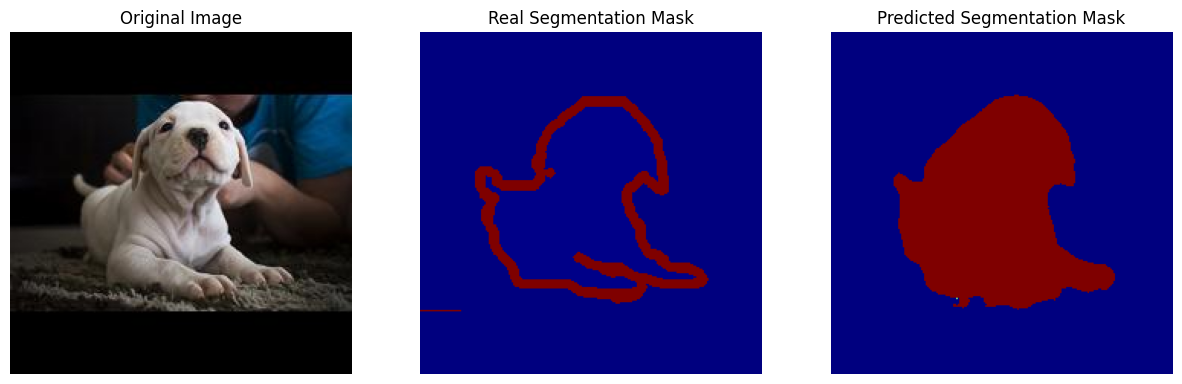

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(torch.load("best_unet.pth", map_location=device))  # Load best model
model.eval()  # Set to evaluation mode

# Define transformation (same as during training)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor (C, H, W)
])

# Load input image and mask
image_path = "/content/dataset/color/american_bulldog_200.jpg"  # Change to your image path
mask_path = "/content/dataset/label/american_bulldog_200.png"  # Change to real mask path

image = Image.open(image_path).convert("RGB")  # Ensure 3-channel image
real_mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale (single-channel)

# Transform input image
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension (1, C, H, W)

# Forward pass through U-Net
with torch.no_grad():
    output = model(input_tensor)  # Output shape: (1, num_classes, H, W)
    predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Convert to numpy

# Convert real mask to numpy
real_mask_np = np.array(real_mask)

# Get unique classes
unique_classes = torch.unique(torch.tensor(predicted_mask))
print(f"Unique classes in predicted mask: {unique_classes.tolist()}")

# Display input image, real mask, and predicted segmentation mask
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Original image
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

# Real segmentation mask
ax[1].imshow(real_mask_np, cmap="jet")  # Using "jet" for better visualization
ax[1].set_title("Real Segmentation Mask")
ax[1].axis("off")

# Predicted segmentation mask
ax[2].imshow(predicted_mask, cmap="jet")
ax[2].set_title("Predicted Segmentation Mask")
ax[2].axis("off")

plt.show()
